In [54]:
import keras 
from keras import layers
from keras import optimizers
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

      Unnamed: 0         img name  tumor types
0              0           000137            1
1              1         case0419            1
2              2         case0024            0
3              3     benign (397)            0
4              4         case0287            0
...          ...              ...          ...
2379        2379  malignant (143)            1
2380        2380         case0441            1
2381        2381     benign (162)            0
2382        2382           000064            0
2383        2383           000022            0

[2384 rows x 3 columns]


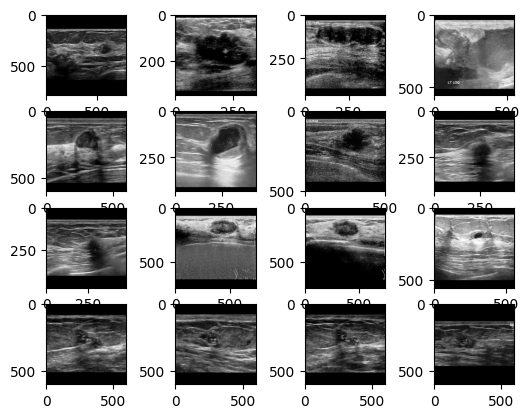

In [47]:
## load the cancer dataset
def load_imgs(show_sample = True):
    
    ## (1) Data preparation
    df=pd.read_csv('train.csv', sep = ',')
    print(df)
    
    #x_test = np.empty((2384, 988, 988))
    
    #for i in range(x_test.shape[0]):
    #    x_test[i] = cv.imread("testImgs/" + str(i) + ".png", 0)
    
    #need to do some sort of zero/same padding to get same image sizes
    # unless using fully convolutional NN bc can take inputs of different sizes
    # or if use a spatial pyramid pooling (SPP) layer before dense layers
    
    #Could possibly create more training data thru upscaling/downscaling
    # would better recognise diff scaled data
    
    # store training and test imgs greyscaled
    x_train = np.array([cv.imread("trainImgs/" + row[1] + ".png", 0) for row in df.values], dtype=object)
    x_test = np.array([cv.imread("testImgs/" + str(i) + ".png", 0) for i in range(1248)], dtype=object)
    #shapes of both are messed up
    
    #store whether benign (0?) or malignant (1?)
    y_train = np.array([row[2] for row in df.values], dtype=object)
    y_test = 0 #no labels on test data??
    
    #show first 100 images
    if show_sample == True:
        nImg = 4
        for i in range(nImg*nImg):
            plt.subplot(nImg, nImg, i+1)
            plt.imshow(x_train[i], cmap = 'Greys_r')
        plt.show()
        
    #x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1] * x_train.shape[2]]) #adds 2nd dim of 1
    #x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]]) #adds 2nd dim of 1
        
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_imgs()

#print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
#print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


In [55]:
# expand dims for channels?

desiredLevels = 2

def CreateConvLayer(convLayers, model, filters, kernel_size, activation = None, padding = "valid"):
    conv = layers.Conv2D(
        filters= filters, #num of filters for conv
        kernel_size = kernel_size, 
        padding = padding,
        activation = activation,
        #input_shape = (28, 28, 1) #only 28 params 
    )
    
    convLayers.append(conv)
    model.add(conv)
    
def CreateMaxPoolLayer(poolLayers, model, pool_size, strides):
    pool = layers.MaxPooling2D(
        pool_size = pool_size,
        strides = strides,
    )
    
    poolLayers.append(pool)
    model.add(pool)
    
def CreateConvBlock(
    model, convLayers, poolLayers, normLayers, activationLayers,
    filters, kernel_size, activation,
    pool_size, strides
):
    CreateConvLayer(convLayers, model, filters, kernel_size)
    #CreateMaxPoolLayer(poolLayers, model, pool_size, strides)
    
    dropout = layers.Dropout(0.2)
    model.add(dropout)
    
    norm = layers.BatchNormalization()
    model.add(norm)
    normLayers.append(norm)

    activ = layers.Activation(activation)
    model.add(activ)
    activationLayers.append(activ)
    
# Create a fully conv NN
model_fcn = keras.Sequential()

convLayers = []
poolLayers = []
normLayers = []
activationLayers = []

# Input layer
input = layers.Input(shape=(None, None, 1))
model_fcn.add(input)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=8, kernel_size=3, activation='relu',
    pool_size=2, strides=2
)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=16, kernel_size=3, activation='softmax',
    pool_size=2, strides=2
)

globMaxPool = layers.GlobalMaxPooling2D()
model_fcn.add(globMaxPool)

model_fcn(inputs=x_train, outputs=y_train)

#need normalization and output layers

#specify optimization
model_fcn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_fcn.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, None, None, 8)     80        
                                                                 
 dropout_2 (Dropout)         (None, None, None, 8)     0         
                                                                 
 batch_normalization_2 (Batc  (None, None, None, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, None, 8)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 dropout_3 (Dropout)         (None, None, None, 16)    0         
                                                      

In [ ]:
#train model
history = model_fcn.fit(
    x_train, #should be 2d inputs
    y_train, #already onehot
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)

In [ ]:
#test accuracy
y_test_pred = model_fcn.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) #still need to do bc pred is prob?
test_err = np.sum(y_test == y_test_pred) / y_test.shape[0]

print(f'test accuracy: {test_err * 100}')

In [ ]:
#history of training and validation accuracu
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training acc', 'validation acc'])

In [ ]:
#get access to filters/kernels
weights = convLayers[0].get_weights()[0][:, :, 0, :] #arr of a buncha nested lists, 0 bc only have 1 channel (28, 28, 1, 8)

#can get access to other params this way 

for i in range(1, 8):
    plt.subplot(2, 4, i)
    plt.imshow(weights[:,:,i], cmap="gray")
plt.show()

#how get access to feature maps?